<a href="https://colab.research.google.com/github/AnnaGolovaha/PyTorch_MNIST/blob/main/PyTorch_%D1%86%D0%B8%D1%84%D1%80%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F #для функций
import torchvision as tv

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm #этот модуль нужен для того, чтобы видеть, что сейчас происходит в НС (учится она или нет)

In [ ]:
trans = tv.transforms.Compose ([
    tv.transforms.ToTensor() #первод PIL изображения в тензор
]) #трансформация, которая объединяет несколько трансфомаций

In [ ]:
ds_mnist = tv.datasets.MNIST('./datasets', download=True, transform = trans )

100%|██████████| 9912422/9912422 [00:00<00:00, 70856900.05it/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 6239926.54it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 21491739.71it/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13039376.30it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [ ]:
ds_mnist[0][0].numpy()[0].shape

(28, 28)

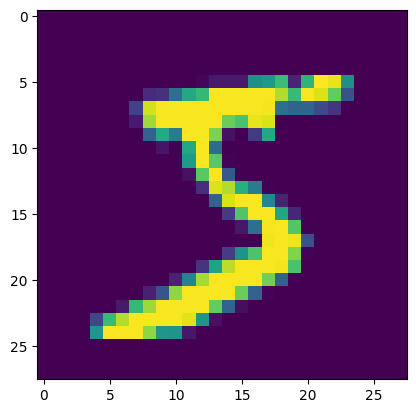

In [ ]:
plt.imshow(ds_mnist[0][0].numpy()[0]) #рисуем первую картинку в датасете

#визуализировать можно именно numpy файл, для него мы убираем первую размерность [0]

In [ ]:
batch_size = 16
dataloader = torch.utils.data. DataLoader(
    ds_mnist, batch_size = batch_size, shuffle = True,
    num_workers =1, drop_last = True #num_workers-кол-во потоков(0-все потоки), drop_last -чтобы не было маленьких батчей
    )

In [ ]:
for img, label in dataloader:
  print(img.shape)
  print(label.shape)
  break

torch.Size([16, 1, 28, 28])
torch.Size([16])


In [ ]:
class Neural_numbers(nn.Module): #наследуем класс от nn.Module
  def __init__(self):
    super().__init__() #нужна, т.к. мы переписываем конструктор модуля, от которого наследуем (обращаемся к высшему классу, иначе будет ошибка)

# /////////////////// ПЕРВЫЙ ВАРИАНТ РЕАЛИЗАЦИИ МОДЕЛИ
    # linear1 = nn.Linear(28*28,100)
    # linear2 = nn.Linear(100,10)
    # act = nn.Relu()

  #   self.model = nn.Sequential(linear1, act, linear2)

  # def forward(self,x): #сначала передаём класс self, затем тензор
  #    return self.model(x)
# //////////////////

    # ВТОРОЙ ВАРИАНТ
    self.flat = nn.Flatten() #чтобы была правильная размерность (делаем один длинный вектор)
    self.linear1 = nn.Linear(28*28,100)
    self.linear2 = nn.Linear(100,10)
    self.act = nn.ReLU()

  def forward(self, x):
    out = self.flat(x)
    out = self.linear1(out)
    out = self.act(out)
    out = self.linear2(out)

    return out

In [ ]:
def count_parameers(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
model =  Neural_numbers()

In [ ]:
count_parameers(model) #число параметров сети

79510

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
optimazer = torch.optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.9) #стохастический градиентный спуск

In [ ]:
def accuracy(pred, label):
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)

  # detach() удаляет граф вычислений (как бы историю) с тензора. Отвязывает.
# Back propagation не будет идти дальше этого тензора.

  return answer.mean()

In [ ]:
epochs = 10

# for epoch in range(epochs):
#   loss_val = 0
#   acc_val = 0
#   # тут будут пачки по 16 сэмплов
#   for img, label in (pbar := tqdm(dataloader)): #для каждого изображения считается loss и градиент


for epoch in range(epochs):
  loss_val = 0
  acc_val = 0
  for img, label in (pbar := tqdm(dataloader)):
    optimazer.zero_grad()  #обновляем градиенты


    label = (torch.Tensor(F.one_hot(label, 10))).float() #здесь 16 тензоров по 10 значений(на нужном классе стоит 1)
    # label - это метка нужного класса, т.е. цифра от 1 до 10
    #  one_hot - эта функция создаст тензоры(по количеству картинок), в которых будут только 0, а 1 встанет на место под индексом, который равен label
    # количество label = кол-ву картинок, столько будет тензоров по 10 чисел в каждом(9 нулей и 1 единичка на нужном месте)

    pred = model(img) #здесь 10 значений (для каждого класса) в 16 тензорах(размер батча)

    loss = loss_fn(pred, label)

    loss.backward()
    loss_item = loss.item()
    loss_val += loss_item

    optimazer.step()

    acc_current = accuracy(pred, label)
    acc_val += acc_current #мы же выводим среднее, поэтому суммируем


    pbar.set_description(f'loss: {loss_item:.5f}\taccuracy: {acc_current:.3f}')

  print(loss_val/len(dataloader))
  print(acc_val/len(dataloader))


  0%|          | 0/3750 [00:00<?, ?it/s]<ipython-input-14-de3baa1e709e>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
loss: 0.67444	accuracy: 0.812: 100%|██████████| 3750/3750 [00:41<00:00, 89.49it/s]


0.6299943087100983
0.8494166666666667


loss: 0.10415	accuracy: 0.938: 100%|██████████| 3750/3750 [00:41<00:00, 89.63it/s]


0.31130893300076323
0.91215


loss: 0.34429	accuracy: 0.938: 100%|██████████| 3750/3750 [00:42<00:00, 88.93it/s]


0.2632068253089984
0.9243166666666667


loss: 0.34685	accuracy: 0.875: 100%|██████████| 3750/3750 [00:41<00:00, 90.08it/s]


0.22960266724824904
0.9348666666666666


loss: 0.23417	accuracy: 0.938: 100%|██████████| 3750/3750 [00:40<00:00, 91.48it/s]


0.2039093686853846
0.9424166666666667


loss: 0.01917	accuracy: 1.000: 100%|██████████| 3750/3750 [00:41<00:00, 90.69it/s]


0.183243716772149
0.9490666666666666


loss: 0.08453	accuracy: 1.000: 100%|██████████| 3750/3750 [00:42<00:00, 88.98it/s]


0.16621748359066746
0.9534333333333334


loss: 0.02338	accuracy: 1.000: 100%|██████████| 3750/3750 [00:41<00:00, 89.75it/s]


0.15248123980549474
0.9571333333333333


loss: 0.13061	accuracy: 0.938: 100%|██████████| 3750/3750 [00:41<00:00, 90.00it/s] 


0.14032025589086117
0.9603166666666667


loss: 0.29467	accuracy: 0.938: 100%|██████████| 3750/3750 [00:41<00:00, 90.59it/s]

0.12989634718690068
0.9637666666666667


In [ ]:
accuracy(pred, label)

<ipython-input-14-de3baa1e709e>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)


0.9375

In [ ]:
# проверка работы НС на тестовом изображении
img = cv2.imread('/content/проверка_MNIST/8.png', cv2.IMREAD_GRAYSCALE)
img = np.expand_dims(img, axis = 0) #эти две строки меняют формат с (28,28) на (1,1,28,28), который используется в этой НС
img = np.expand_dims(img, axis = 0)

img = img.astype(np.float32)/255.0 #делим для того, чтобы значения пикселей были от 0 до 1, при этом во float
# plt.imshow('/content/проверка_MNIST/8.png')

In [ ]:
t_img = torch.from_numpy(img) #переводим в numpy массив
test_pred = model(t_img)

#F.softmax(test_pred).detach().numpy().argmax() #можно закомментировать argmax и посмотреть вероятности

RuntimeError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')